<a href="https://colab.research.google.com/github/GrigoryBartosh/dul_2021/blob/main/Homework/hw10/Homework10_selfsupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 384, done.
remote: Counting objects: 100% (221/221), done.
remote: Compressing objects: 100% (146/146), done.
remote: Total 384 (delta 125), reused 99 (delta 68), pack-reused 163
Receiving objects: 100% (384/384), 55.90 MiB | 31.38 MiB/s, done.
Resolving deltas: 100% (182/182), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=27640 sha256=1c89bdffa7c6f32d5ed2f9bd3136473f7820f53c2224c099f06d0e465ad5e3f9
  Stored in directory: /tmp/pip-ephem-wheel-cache-yoit_70c/wheels/55/59/29/0fb1c6356521

In [27]:
from dul_2021.utils.hw10_utils import *

In [28]:
import torch
import torch.nn as nn
import numpy as np

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Question 1. Context Encoder

Here we will implement [context encoder](https://arxiv.org/abs/1604.07379). The context encoder structures its self-supervised learning task by inpainting masked images. For example, the figure below shows different masking shapes, such as center masking, random block masking, and segmentation masking. Note that segmentation masking (c) is not purely self-supervised since we would need to train a image segmentation model which requires labels. However, the other two masking schemes (a) and (b) and purely self-supervised.

![](https://drive.google.com/uc?id=1fhzkULYTtyMGUUF2n9dlPayJSdcY5pRv)

More formally, the context encoder optimizes the following reconstruction loss:
$$\mathcal{L}_{rec} = \left\Vert \hat{M} \odot (x - F((1 - \hat{M})\odot x)) \right\Vert^2_2$$
where $\hat{M}$ is the masked region, $x$ is the image, and $F$ is the context encoder that tries to reconstruct the masked portion. In addition to the reconstruction loss, the paper introduces an adversarial loss that encourages more realistic inpaintings.
$$L_{adv} = \max_D \mathbb{E}_{x\in \chi} [\log(D(x)) + \log(1 - D(F((1-\hat{M})\odot x)))]$$

In this task we will crop central 14x14 region. You can use slightly afjusted architectures from AVB task from homework 8.

**Hyperparametrs**

* latent_dim = 128
* epochs ~ 10-20
* classifier need fewer updates than encoder-decoder part. We suggest to update it on each 10-th iteration.

**You will provide the following deliverables**


1. Over the course of training, record the mse loss and adversarial losses per batch.
3. 30 (1, 28, 28) images. Where first 10 images are random sample from testdata with removed central region. Next 10 images are reconstracted images with your trained model. Last 10 images are initial without any removal.

In [30]:
plt.rcParams["axes.labelsize"] = 25.
plt.rcParams["xtick.labelsize"] = 20.
plt.rcParams["ytick.labelsize"] = 20.
plt.rcParams["legend.fontsize"] = 18.

plt.rcParams["figure.figsize"] = [20., 6.]

## Conv utils

In [31]:
class DownConv(nn.Module):
  def __init__(self, in_dim, out_dim, kernel_size=(3, 3), stride=2, padding=1, batch_size=128, batch_norm=True):
    super().__init__()
    self.conv = nn.Sequential(nn.Conv2d(in_dim, out_dim, kernel_size, stride, padding),
                              nn.ReLU())
    if batch_norm:
      self.conv = nn.Sequential(self.conv,
                                nn.BatchNorm2d(out_dim))
  def forward(self, x):
    return self.conv(x)

In [32]:
class UpConv(nn.Module):
  def __init__(self, in_dim, out_dim, kernel_size=(2, 2), stride=2, padding=0):
    super().__init__()
    self.conv = nn.Sequential(nn.ConvTranspose2d(in_dim, out_dim, kernel_size, stride, padding),
                              nn.LeakyReLU(2e-1))
  def forward(self, x):
    return self.conv(x)

## Main classes

In [33]:
class Image2Vector(nn.Module):
  def __init__(self, out_dim=128, hid_dim=128, flag="Encoder"):
    super().__init__()
    self.flag = flag
    
    bn = False
    final_conv = DownConv(hid_dim, hid_dim, batch_norm=bn)
    final_layer = nn.Linear(hid_dim, out_dim)
    
    if self.flag == "Encoder":
      final_conv = nn.Sequential(DownConv(hid_dim, hid_dim), DownConv(hid_dim, hid_dim))
      bn = True

    if self.flag == "Discriminator":  
      final_layer = nn.Sequential(final_layer, nn.Sigmoid())

    self.conv = nn.Sequential(DownConv(1, 64, batch_norm=bn),
                              DownConv(64, 128, batch_norm=bn),
                              DownConv(128, hid_dim, batch_norm=bn),
                              final_conv,
                              nn.Flatten(),
                              final_layer)

  def forward(self, x):
    return self.conv(x)

In [34]:
class Decoder(nn.Module):
  def __init__(self, lat_dim=128):
    super().__init__()
    
    self.conv = nn.Sequential(nn.Unflatten(1, torch.Size([lat_dim, 1, 1])),
                              UpConv(128, 128),
                              UpConv(128, 128),
                              UpConv(128, 128),
                              UpConv(128, 128),
                              nn.Conv2d(128, 64, kernel_size=3, stride=2, padding=0),
                              nn.LeakyReLU(1e-2),
                              UpConv(64, 1))

    self.tanh = nn.Tanh()

  def forward(self, x):
    x = self.conv(x)
    x = self.tanh(x)
    return x

In [59]:
encoder = Image2Vector(hid_dim=256).to(device)
discriminator = Image2Vector(out_dim=1, flag="Discriminator").to(device)
decoder = Decoder().to(device)

## Hyperparameters

In [60]:
num_epoch = 15
batch_size = 128

## Loss, data, optimizers

In [61]:
from torch.utils.data import DataLoader
train_dataset, _ = get_mnist()

train_data = DataLoader(train_dataset, batch_size, shuffle=True)
Ones = torch.ones((batch_size, 1), device=device)
Zeros = torch.zeros((batch_size, 1), device=device)

In [62]:
mse = nn.MSELoss()
bce = nn.BCELoss()

In [63]:
from torch.optim import Adam

optim_e = Adam(encoder.parameters(), 2e-4)
optim_dis = Adam(discriminator.parameters(), 1e-5)
optim_dec = Adam(decoder.parameters(), 2e-4)

## Image util

In [64]:
def tensor_to_image(x: torch.Tensor):
  image = x.permute((0, 2, 3, 1)).squeeze(-1)
  image = image.cpu().numpy() + 1
  image *= 128
  image = image.astype(np.uint8)
  
  return image

## Train loop

In [65]:
dis_loss = []
mse_loss = []
grey_square = torch.full((batch_size, 1, 14, 14), 0.0).to(device)

Epoch -- 1
	 MSE -- 39983.867557525635
	 BCE -- 553.4387542009354


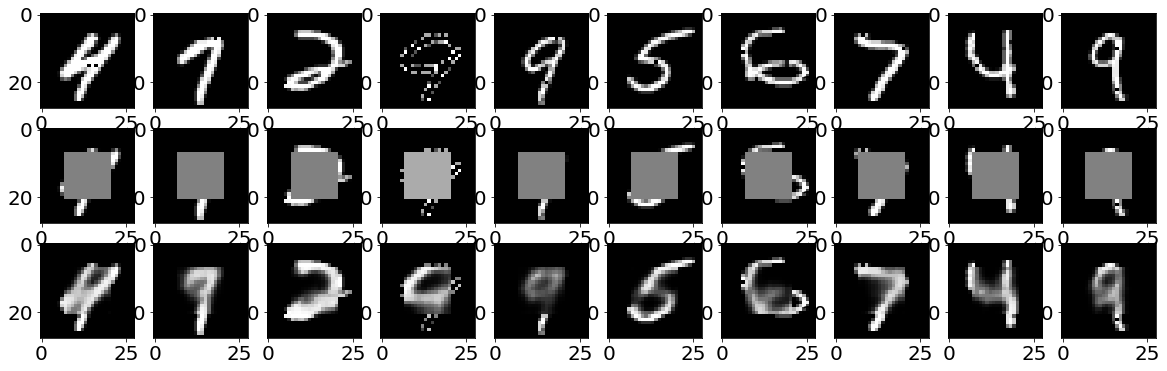

Epoch -- 2
	 MSE -- 26291.46426010132
	 BCE -- 134.7554656341672


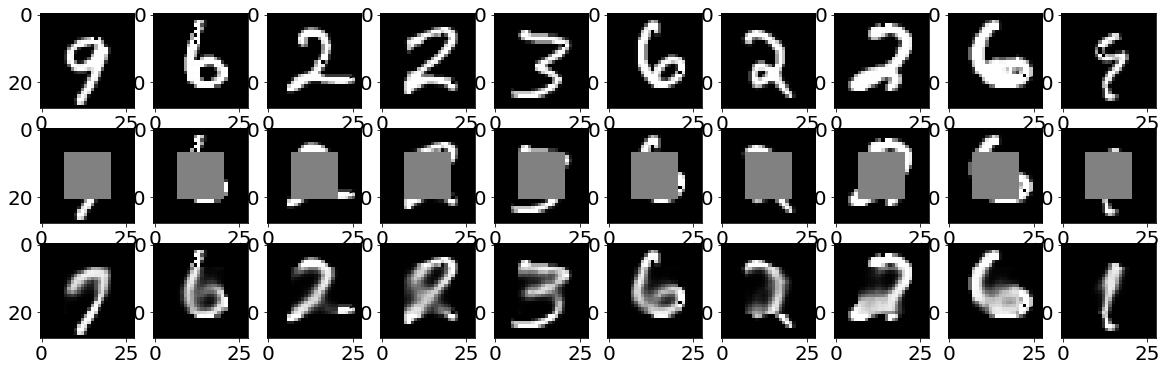

Epoch -- 3
	 MSE -- 24230.956718444824
	 BCE -- 52.07425523549318


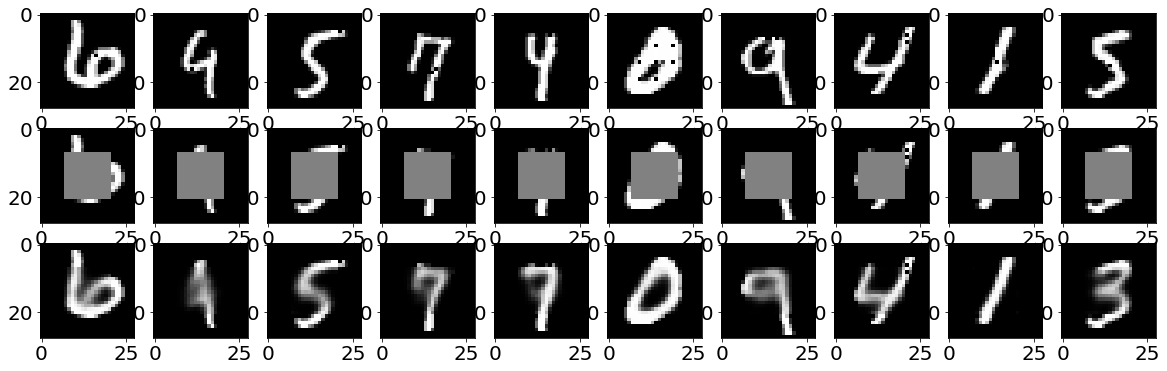

Epoch -- 4
	 MSE -- 23014.011669158936
	 BCE -- 40.182120248675346


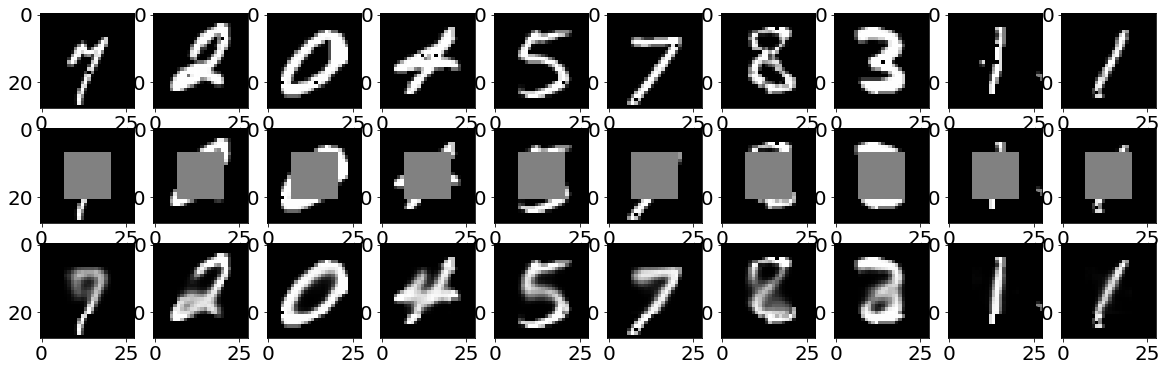

Epoch -- 5
	 MSE -- 22179.211265563965
	 BCE -- 37.41500831767917


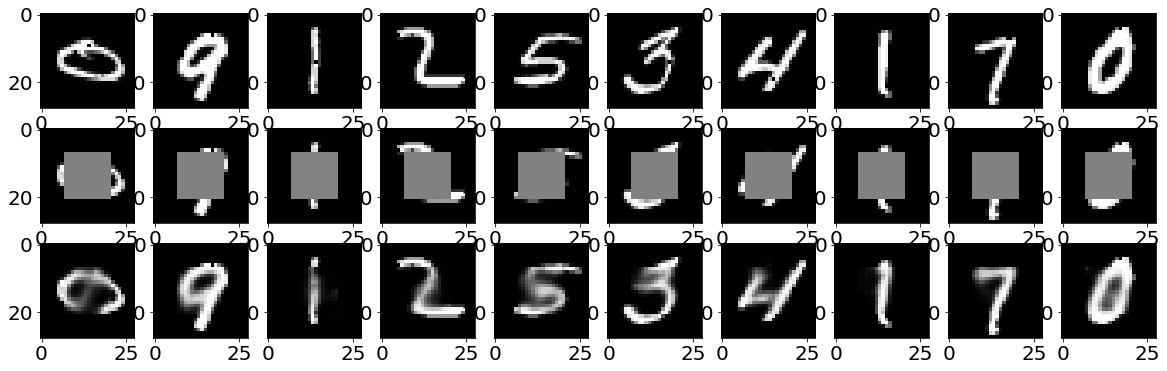

Epoch -- 6
	 MSE -- 21474.80762863159
	 BCE -- 34.283340491354465


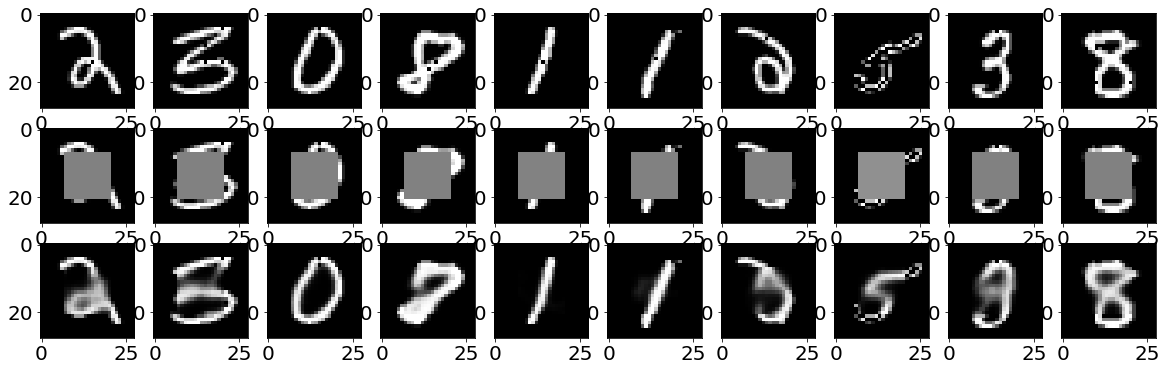

Epoch -- 7
	 MSE -- 20840.824798583984
	 BCE -- 34.94431051239371


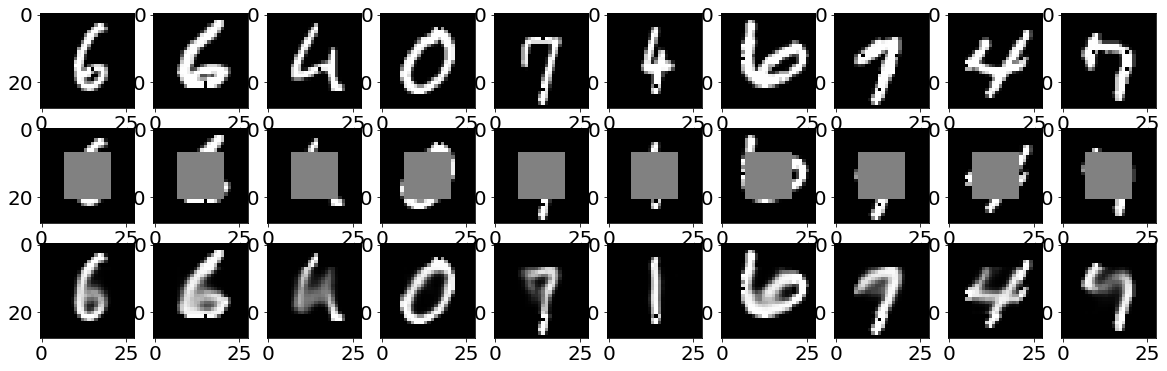

Epoch -- 8
	 MSE -- 20226.2423286438
	 BCE -- 35.29577939212322


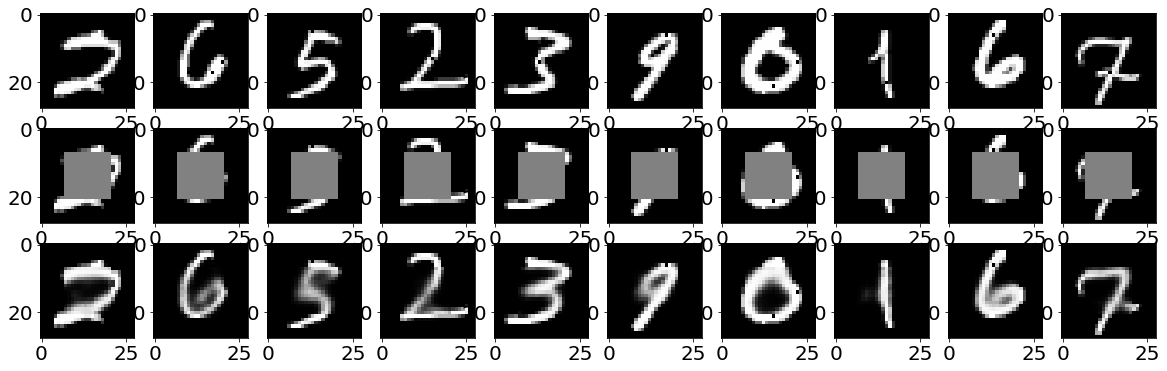

Epoch -- 9
	 MSE -- 19674.912715911865
	 BCE -- 35.171663761138916


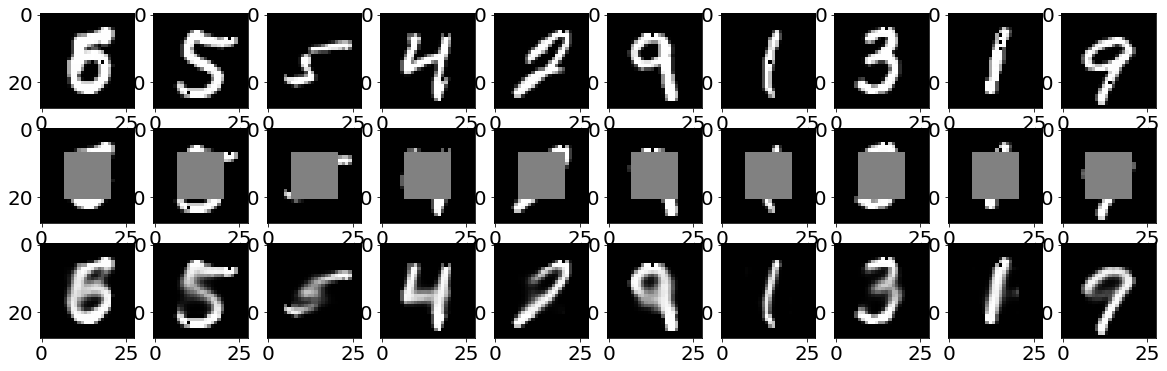

Epoch -- 10
	 MSE -- 19027.246181488037
	 BCE -- 37.299387365579605


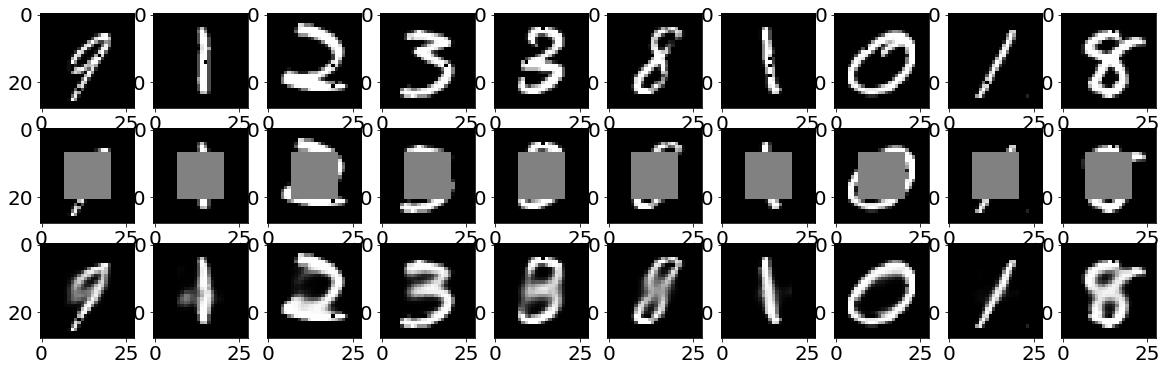

Epoch -- 11
	 MSE -- 18511.28429031372
	 BCE -- 36.8081423714757


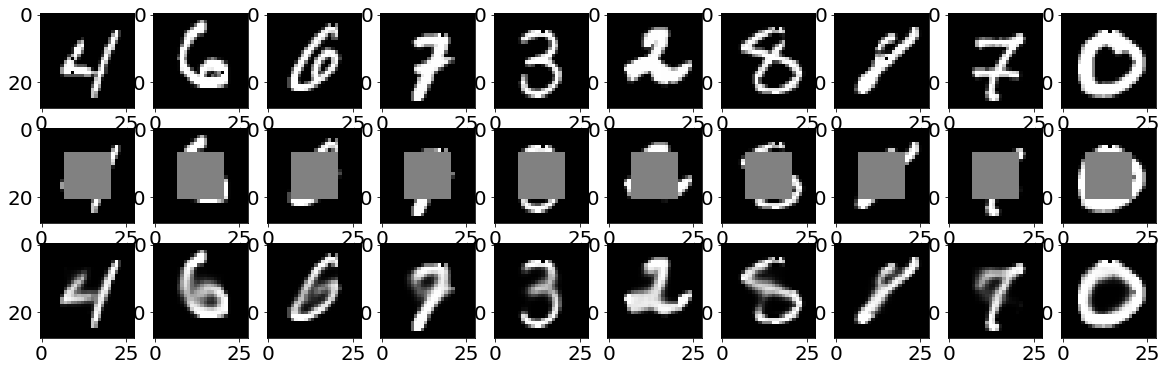

Epoch -- 12
	 MSE -- 17956.245307922363
	 BCE -- 37.744614731520414


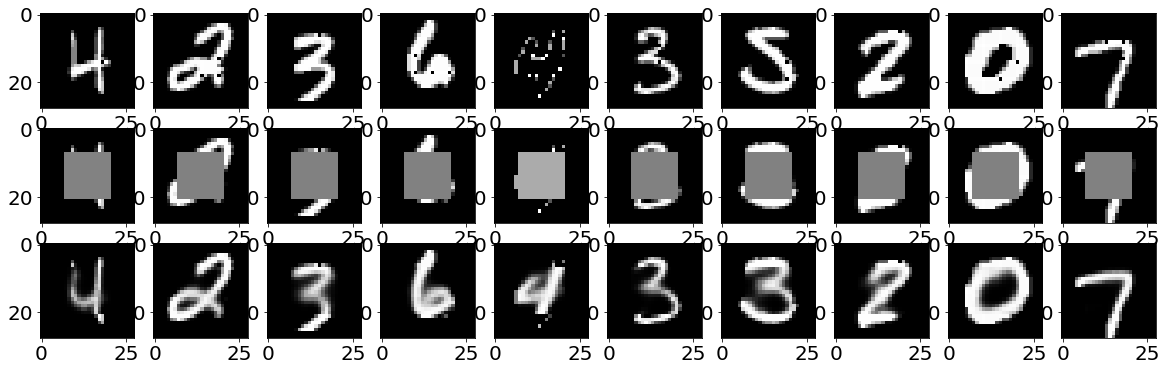

Epoch -- 13
	 MSE -- 17436.702922821045
	 BCE -- 40.693941444158554


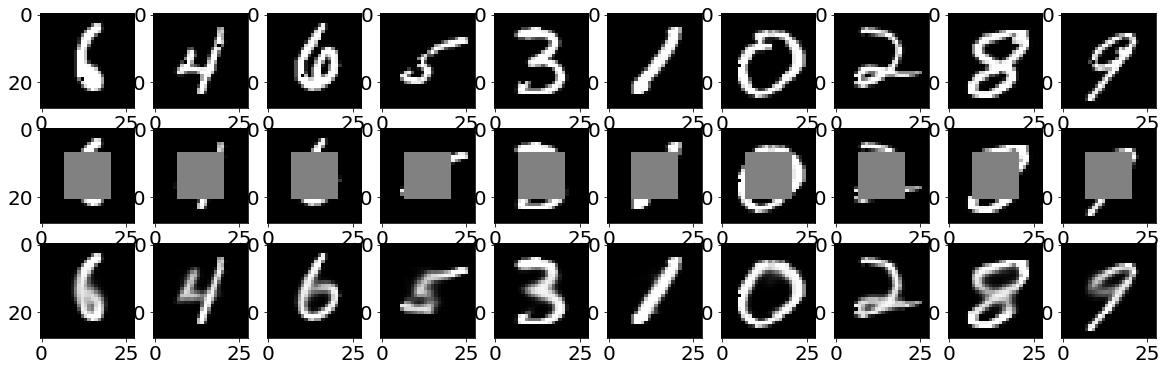

Epoch -- 14
	 MSE -- 16884.658334732056
	 BCE -- 41.30873275920749


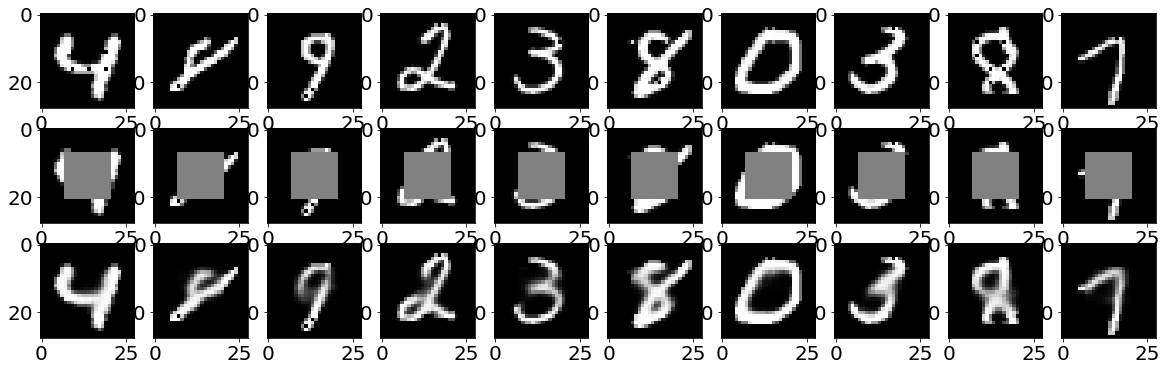

Epoch -- 15
	 MSE -- 16393.304458618164
	 BCE -- 45.76581969857216


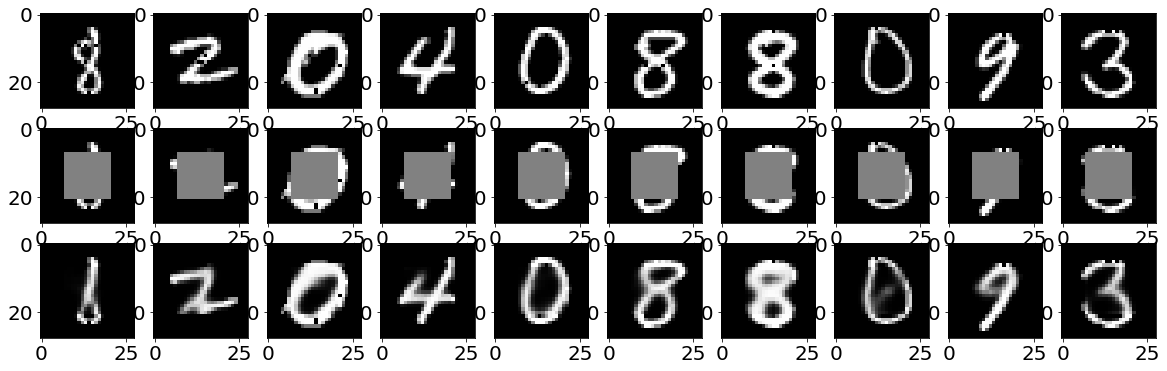

In [66]:
for ep in range(num_epoch):
  M, B = 0, 0
  for i, (x, _) in enumerate(train_data, start=1):
    x = x.to(device)
    y = x.clone()
    N = x.shape[0]

    center = x[:, :, 7:21, 7:21]
    y[:, :, 7:21, 7:21] = grey_square[:N]

    z = encoder(y)
    rec = decoder(z)
    loss_mse = mse(rec.flatten(), center.flatten()) * 14 * 14
    mse_loss.append(loss_mse.item())
    M += mse_loss[-1]

    q_dec = discriminator(rec)
    optim_e.zero_grad()
    optim_dec.zero_grad()
    
    (loss_mse + q_dec.mean()).backward()

    optim_e.step()
    optim_dec.step()
    

    p = discriminator(center)
    q = discriminator(rec.detach())

    input = torch.cat([p, q])
    target = torch.cat([Zeros[:N], Ones[:N]])
    loss_d = bce(input, target) * 2
    dis_loss.append(loss_d.item())
    B += dis_loss[-1]

    optim_dis.zero_grad()
    loss_d.backward()
    optim_dis.step()

    #optim_e.zero_grad()
    #optim_dec.zero_grad()
    #optim_dis.zero_grad()

    #loss = loss_mse + loss_d
    #loss.backward()

    #optim_e.step()
    #optim_dec.step()
    #optim_dis.step()
  
  print(f"Epoch -- {ep + 1}")
  print(f"\t MSE -- {M}")
  print(f"\t BCE -- {B}")

  per = np.random.permutation(10_000)[:10]
  X = torch.zeros((10, 1, 28, 28))
  for i, p in enumerate(per):
    X[i] = train_dataset[p][0]
  X = X.to(device)

  T = X.clone()
  X[:, :, 7:21, 7:21] = grey_square[:X.shape[0]]
  with torch.no_grad():
    z = encoder(X)
    r = decoder(z)

  Y = X.clone()
  Y[:, :, 7:21, 7:21] = r
  
  a = tensor_to_image(T)

  b = tensor_to_image(X)

  c = tensor_to_image(Y)

  for i in range(3):
    for j in range(10):
      if i == 0:
        image = a[j]
      elif i == 1:
        image = b[j]
      else:
        image = c[j]
      
      index = 10 * i + j + 1
      plt.subplot(3, 10, index)
      plt.imshow(image, cmap="gray")
  plt.show()

In [72]:
def q1(train_data, test_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of MNIST images with values from -1 to 1
    test_data: An (n_test, 1, 28, 28) torchvision dataset of MNIST images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array of full of mse losses
    - a (# of training iterations, ) numpy array of full of adversarial losses
    - a (30, 1, 28, 28) numpy array of 10 transformed images, 10 reconstructions, and 10 groundtruths
    """
    N = 10
    per = np.random.permutation(10_000)[:N]
    X = torch.zeros((N, 1, 28, 28))
    for i, p in enumerate(per):
      X[i] = test_data[p][0]
    X = X.to(device)

    T = X.clone()
    X[:, :, 7:21, 7:21] = grey_square[:N]
    with torch.no_grad():
      z = encoder(X)
      r = decoder(z)

    Y = X.clone()
    Y[:, :, 7:21, 7:21] = r
  
    ground_truth = T.cpu().numpy()

    transformed = X.cpu().numpy()

    reconstruction = Y.cpu().numpy()

    images = np.concatenate([transformed, reconstruction, ground_truth], axis=0)

    return [m / (14 * 14) for m in mse_loss], dis_loss, images

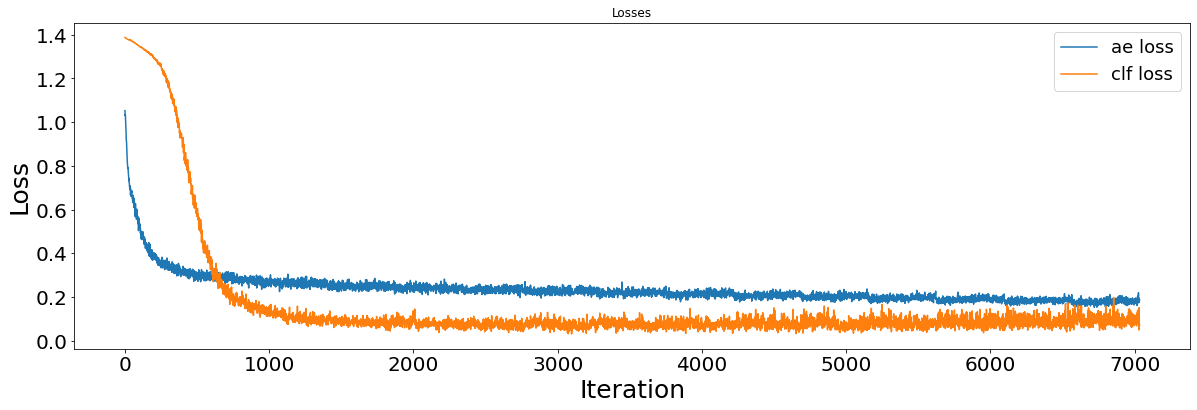

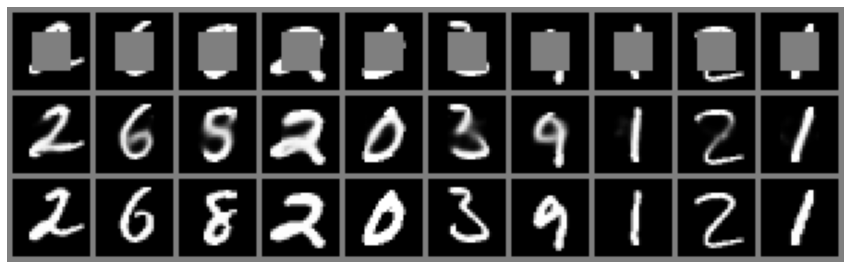

In [73]:
q1_results(q1)

# Question 2. Rotations Prediction

Here we will imlement this [paper](https://arxiv.org/abs/1803.07728). Here, model learns good representations for downstream tasks by proxy task of prediciting rotation of the original image.

![](https://drive.google.com/uc?id=1eHXLH-N_6uMGRzdf1Wjnga26qlS5-FRv)

We will work with same rotations as in paper (0, 90, 180, 270). You can use architecture AVB task in hw8. Latent dim 128 and 10 epochs should be enough.

**You will provide the following deliverables**


1. Over the course of training, record the loss per batch.
2. Over the course of training, record the accuracy score for each iteration.




## Encoder

In [ ]:
class Encoder(nn.Module):
  def __init__(self, lat_dim=128, hid_dim=128):
    super().__init__()
    
    self.body = nn.Sequential(DownConv(1, 64),
                              DownConv(64, 128),
                              DownConv(128, hid_dim),
                              DownConv(hid_dim, hid_dim),
                              DownConv(hid_dim, hid_dim),
                              nn.Flatten(),
                              nn.Linear(hid_dim, lat_dim))

  def forward(self, x):
    x = self.body(x)
    #return self.head(x)
    return x

## Hyperparameters

In [ ]:
num_epoch = 10
batch_size = 128
lat_dim = 128

## Model

In [ ]:
encoder = Encoder(lat_dim=lat_dim, hid_dim=256)
classifier = nn.Sequential(nn.Linear(lat_dim, 128), nn.Linear(128, 4))

rotnet = nn.Sequential(encoder, classifier).to(device)

In [ ]:
from torch.optim import Adam

opt = Adam(rotnet.parameters(), 2e-4)
cross_entropy = nn.CrossEntropyLoss()

## Load data

In [ ]:
from torch.utils.data import DataLoader

train_dataset, test_dataset = get_mnist()
train_data = DataLoader(train_dataset, batch_size, shuffle=True)
test_data = DataLoader(test_dataset, batch_size, shuffle=True)

## Batch rotation

In [ ]:
from torchvision.transforms.functional import rotate

def get_rotated(x: torch.Tensor):
  N = x.shape[0]
  rotations = torch.randint(low=0, high=4, size=(N,), device=device)

  for i in range(1, 4):
    idx = torch.where(rotations == i)
    x[idx] = rotate(x[idx], 90. * i)

  return x, rotations

## Train loop

In [ ]:
Accuracy = []
Loss = []

In [ ]:
for epoch in range(num_epoch):
  rotnet.train()
  for x, _ in train_data:
    x = x.to(device)
    x, target = get_rotated(x)

    logit = rotnet(x)
    loss = cross_entropy(logit, target)
    
    Loss.append(loss.item())
    
    opt.zero_grad()
    loss.backward()
    opt.step()

  rotnet.eval()
  # Accuracy on epoch
  Accuracy.append(0)
  for x, _ in train_data:
    x = x.to(device)
    x, target = get_rotated(x)

    with torch.no_grad():
      logit = rotnet(x)
      labels = torch.argmax(logit, dim=1)

    Accuracy[-1] += (labels == target).sum().item()

  Accuracy[-1] /= len(train_dataset)
  print(f"Epoch : {epoch}")
  print(f"\t Accuracy = {Accuracy[-1]}")

Epoch : 0
	 Accuracy = 0.9810666666666666
Epoch : 1
	 Accuracy = 0.9734166666666667
Epoch : 2
	 Accuracy = 0.99015
Epoch : 3
	 Accuracy = 0.9888333333333333
Epoch : 4
	 Accuracy = 0.9931
Epoch : 5
	 Accuracy = 0.9893
Epoch : 6
	 Accuracy = 0.99385
Epoch : 7
	 Accuracy = 0.99475
Epoch : 8
	 Accuracy = 0.9931
Epoch : 9
	 Accuracy = 0.9954833333333334


## Results

In [ ]:
def q2(train_data):
  """
  train_data: An (n_train, 1, 28, 28) torchvision dataset of MNIST images with values from -1 to 1
  Returns
  - a (# of training iterations, ) numpy array of full of losses
  - a (# of training epochs, ) numpy array of full of accuracy scores
  """
  return Loss, Accuracy 

In [ ]:
plt.rcParams["axes.labelsize"] = 25.
plt.rcParams["xtick.labelsize"] = 20.
plt.rcParams["ytick.labelsize"] = 20.
plt.rcParams["legend.fontsize"] = 18.

plt.rcParams["figure.figsize"] = [10., 10.]

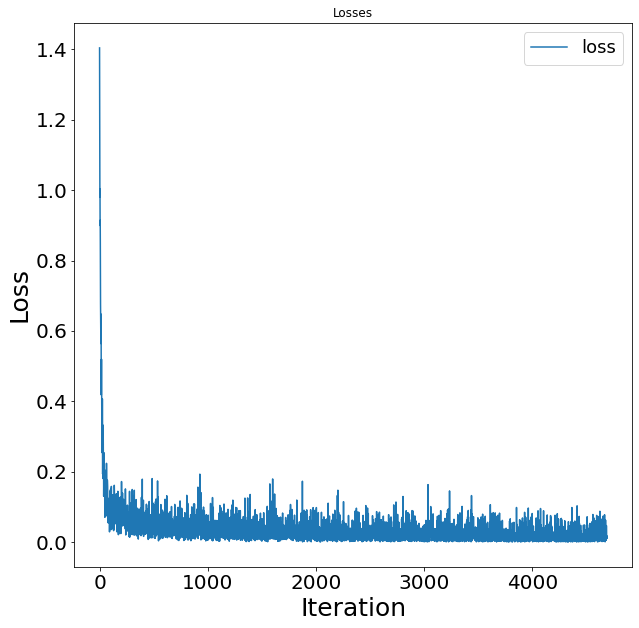

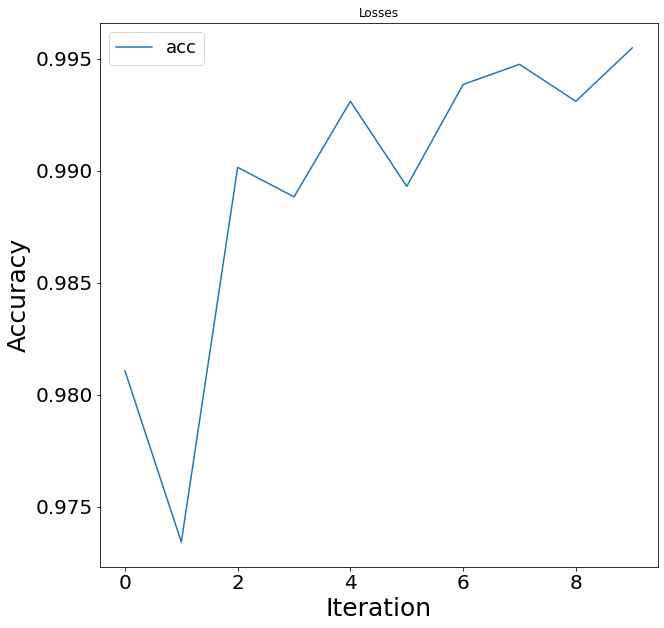

In [ ]:
q2_results(q2)

## Downstream task: digit classification

In [ ]:
from torch.utils.data import Subset

idx = np.random.permutation(60_000)[:1_000]
train_subset = Subset(train_dataset, idx)
train_subset = DataLoader(train_subset, batch_size=batch_size, shuffle=True)

In [ ]:
random_encoder = Encoder(lat_dim=lat_dim, hid_dim=256)

In [ ]:
for p in encoder.body.parameters():
  p.requires_grad = False

for q in random_encoder.body.parameters():
  q.requires_grad = False

In [ ]:
classifier_self = nn.Sequential(encoder, nn.Linear(lat_dim, 10)).to(device)
classifier_random = nn.Sequential(random_encoder, nn.Linear(lat_dim, 10)).to(device)

opt_self = Adam(classifier_self.parameters(), 2e-4)
opt_random = Adam(classifier_random.parameters(), 2e-4)

In [ ]:
def train(classifier, opt, train_data):
  Accuracy = []
  for epoch in range(40):
    classifier.train()
    for x, target in train_data:
      x = x.to(device)
      target = target.to(device)

      logit = classifier(x)
      loss = cross_entropy(logit, target)

      opt.zero_grad()
      loss.backward()
      opt.step()
    
    classifier.eval()
    Accuracy.append(0)
    for x, target in test_data:
      x = x.to(device)
      target = target.to(device)
      with torch.no_grad():
        logit = classifier(x)
        labels = torch.argmax(logit, dim=1)

      Accuracy[-1] += (labels == target).sum().item()

    Accuracy[-1] /= len(test_dataset)

  return Accuracy

In [ ]:
ac_1 = train(classifier_self, opt_self, train_subset)
ac_2 = train(classifier_random, opt_random, train_subset)

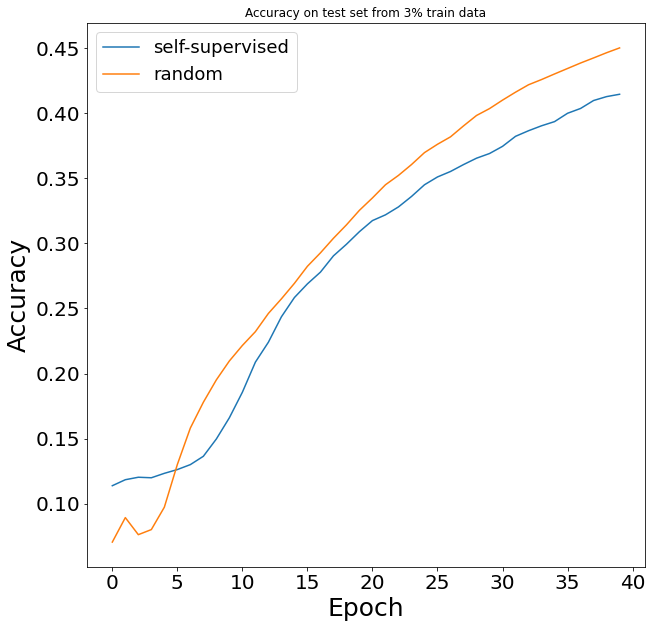

In [ ]:
plt.plot(ac_1, label="self-supervised")
plt.plot(ac_2, label="random")

plt.title("Accuracy on test set from 3% train data")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()